##### Perubahan
- pake smote
- pake hyperparameter tuning
- pake cross validation
- encoding bener

#### Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pickle
from sklearn.model_selection import StratifiedKFold, cross_val_score
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

#### Load Dataset

In [143]:
pregnancy_df = pd.read_csv('pregnancy-dataset.csv')
pregnancy_df.head()

,nama,umur_ibu,gravida,TiTi_Tika,umur_kehamilan,berat_ibu,tinggi_badan,tekanan_darah,penyakit_anemia,penyakit_kuning,posisi_janin,gerakan_janin,denyut_jantung_janin,kadar_albumin,tes_kadar_gula,hasil_tes_VDRL,hasil_tes_HbsAg,tingkat_risiko_kehamilan
0,Rituporna,18,1st,1st,38 week,50 kg,5.3'',100/60,NaN,NaN,Normal,Normal,140m,NaN,Yes,Negative,Negative,Yes
1,Moina,25,2nd,2nd,38 week,60 kg,5.2'',100/70,NaN,NaN,Normal,Normal,130m,NaN,Yes,Positive,Negative,No
2,Rabeya,20,1st,1st,30 week,55 kg,5.0'',100/60,NaN,NaN,Normal,Normal,120m,NaN,Yes,Negative,Negative,Yes
3,Shorna,22,1st,3rd,35 week,51 kg,5.4'',110/65,NaN,NaN,Normal,Normal,130m,NaN,Yes,Positive,Negative,Yes
4,Tania Akter,20,1st,2nd,30 week,53 kg,5.2'',100/55,NaN,NaN,Normal,Normal,125m,NaN,Yes,Negative,Negative,No


In [144]:
print("Informasi dataset:")
pregnancy_df.info()

# Cek value setiap kolom/tipe data satu per satu dengan loop
for dtype, col in (list(zip(pregnancy_df.dtypes, pregnancy_df.columns))):
    if dtype == 'int64' or dtype == 'float64':
        print(col, dtype)
        print(pregnancy_df[col].min(), pregnancy_df[col].max())
    else:
        print(col, dtype)
        print(pregnancy_df[col].unique()[:3])

    print()



Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   nama                      998 non-null    object
 1   umur_ibu                  998 non-null    int64 
 2   gravida                   998 non-null    object
 3   TiTi_Tika                 998 non-null    object
 4   umur_kehamilan            998 non-null    object
 5   berat_ibu                 998 non-null    object
 6   tinggi_badan              998 non-null    object
 7   tekanan_darah             998 non-null    object
 8   penyakit_anemia           123 non-null    object
 9   penyakit_kuning           12 non-null     object
 10  posisi_janin              998 non-null    object
 11  gerakan_janin             998 non-null    object
 12  denyut_jantung_janin      998 non-null    object
 13  kadar_albumin             134 non-null    object
 14  tes_kad

In [145]:
tingkat_risiko_kehamilan = pregnancy_df['tingkat_risiko_kehamilan']
tingkat_risiko_kehamilan.value_counts()

tingkat_risiko_kehamilan
Yes    666
No     332
Name: count, dtype: int64

In [146]:
print("\nMissing values per fitur:")
print(pregnancy_df.isnull().sum())


Missing values per fitur:
nama                          0
umur_ibu                      0
gravida                       0
TiTi_Tika                     0
umur_kehamilan                0
berat_ibu                     0
tinggi_badan                  0
tekanan_darah                 0
penyakit_anemia             875
penyakit_kuning             986
posisi_janin                  0
gerakan_janin                 0
denyut_jantung_janin          0
kadar_albumin               864
tes_kadar_gula                0
hasil_tes_VDRL                0
hasil_tes_HbsAg               0
tingkat_risiko_kehamilan      0
dtype: int64


##### Analisis
1. Ada 998 baris dan 18 fitur data
2. Tipe data ada yg masih belum sesuai (hanya fitur kolom ibu yg tipe datanya int)
3. Ada 875 missvalues di fitur penyakit_anemia, 986 missvalues di fitur penyakit_kuning, dan 864 missvalues di fitur kadar_albumin
4. Masih banyak data yg isinya campuran, seperti 38 week, 1st, dll
5. Kalau berdasarkan penilaian peneliti sebelumnya perbandingan ibu berisiko tinggi dibandingkan ibu tidak berisiko tinggi kehamilan pd dataset, yaitu 2 : 1.

Note :
- Fitur yg akan dipakai adalah fitur  (umur_ibu, gravida, umur_kehamilan, tinggi_badan, tekanan_darah, penyakit_anemia, posisi_janin, hasil_tes_VDRL, hasil_tes_HbsAg)

#### Data Cleaning

In [147]:
# Memilih kolom yang akan digunakan
selected_columns = ['umur_ibu', 'gravida', 'umur_kehamilan', 'tinggi_badan',
                    'tekanan_darah', 'penyakit_anemia', 'posisi_janin', 'hasil_tes_VDRL', 'hasil_tes_HbsAg']

pregnancydf_selected = pregnancy_df[selected_columns].copy()
print("Informasi dataset:")
pregnancydf_selected.info()

Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   umur_ibu         998 non-null    int64 
 1   gravida          998 non-null    object
 2   umur_kehamilan   998 non-null    object
 3   tinggi_badan     998 non-null    object
 4   tekanan_darah    998 non-null    object
 5   penyakit_anemia  123 non-null    object
 6   posisi_janin     998 non-null    object
 7   hasil_tes_VDRL   998 non-null    object
 8   hasil_tes_HbsAg  998 non-null    object
dtypes: int64(1), object(8)
memory usage: 70.3+ KB


In [148]:
# Membersihkan fitur 'gravida' (mengambil hanya angka)
pregnancydf_selected['gravida'] = pregnancydf_selected['gravida'].str.extract(r'(\d+)').astype(int)

# Membersihkan fitur 'umur_kehamilan' (menghapus kata "week")
pregnancydf_selected['umur_kehamilan'] = pregnancydf_selected['umur_kehamilan'].str.replace(r'\D+', '', regex=True).astype(int)

# Fungsi konversi tinggi badan dari feet ke cm
def feet_to_cm(value):
    try:
        feet, inches = map(float, value.replace('"', '').replace("'", '').split('.'))
        return round((feet * 30.48) + (inches * 2.54), 2)  # Menghasilkan float dengan 2 desimal
    except:
        return None  # Mengembalikan None jika ada kesalahan format

# Mengubah tinggi_badan ke cm dan mengonversinya ke float
pregnancydf_selected['tinggi_badan'] = pregnancydf_selected['tinggi_badan'].apply(feet_to_cm).astype(float)

# Memisahkan tekanan darah menjadi dua kolom, tetap string dulu
pregnancydf_selected[['tekanan_sistolik', 'tekanan_diastolik']] = pregnancydf_selected['tekanan_darah'].str.split('/', expand=True)

# Konversi ke integer
pregnancydf_selected['tekanan_sistolik'] = pregnancydf_selected['tekanan_sistolik'].astype(int)
pregnancydf_selected['tekanan_diastolik'] = pregnancydf_selected['tekanan_diastolik'].astype(int)

# Hapus kolom tekanan_darah jika tidak diperlukan
pregnancydf_selected.drop(columns=['tekanan_darah'], inplace=True)

# Fungsi klasifikasi tekanan darah
def klasifikasi_tekanan_darah(s, d):
    if s < 90 or d < 60:
        return 'Hipotensi'
    elif 90 <= s < 120 and 60 <= d < 80:
        return 'Normal'
    elif 120 <= s < 140 or 80 <= d < 90:
        return 'Prehipertensi'
    elif 140 <= s < 160 or 90 <= d < 100:
        return 'Hipertensi Stage 1'
    elif s >= 160 or d >= 100:
        return 'Hipertensi Stage 2'
    else:
        return 'Tidak diketahui'

# Terapkan fungsi ke dataframe
pregnancydf_selected['kategori_tekanan_darah'] = pregnancydf_selected.apply(
    lambda row: klasifikasi_tekanan_darah(row['tekanan_sistolik'], row['tekanan_diastolik']),
    axis=1
)

# Mengecek hasil akhir
print(pregnancydf_selected.dtypes)
pregnancydf_selected.head()

umur_ibu                    int64
gravida                     int32
umur_kehamilan              int32
tinggi_badan              float64
penyakit_anemia            object
posisi_janin               object
hasil_tes_VDRL             object
hasil_tes_HbsAg            object
tekanan_sistolik            int32
tekanan_diastolik           int32
kategori_tekanan_darah     object
dtype: object


,umur_ibu,gravida,umur_kehamilan,tinggi_badan,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,tekanan_sistolik,tekanan_diastolik,kategori_tekanan_darah
0,18,1,38,160.02,NaN,Normal,Negative,Negative,100,60,Normal
1,25,2,38,157.48,NaN,Normal,Positive,Negative,100,70,Normal
2,20,1,30,152.40,NaN,Normal,Negative,Negative,100,60,Normal
3,22,1,35,162.56,NaN,Normal,Positive,Negative,110,65,Normal
4,20,1,30,157.48,NaN,Normal,Negative,Negative,100,55,Hipotensi


In [149]:
# Cek missing values
print("\nMissing values per fitur:")
print(pregnancydf_selected.isnull().sum())


Missing values per fitur:
umur_ibu                    0
gravida                     0
umur_kehamilan              0
tinggi_badan                0
penyakit_anemia           875
posisi_janin                0
hasil_tes_VDRL              0
hasil_tes_HbsAg             0
tekanan_sistolik            0
tekanan_diastolik           0
kategori_tekanan_darah      0
dtype: int64


##### Alasan jumlah missing values banyak
Sepertinya karena nilai default dari dataset yg menyebutkan jk ibu hamil yg tidak memiliki penyakit anemia dituliskan dg None. Oleh karena itu, kata None akan diganti dengan kata negatif

In [150]:
# Agar kata none tidak didefinisikan sbg NaN
pregnancydf_selected[['penyakit_anemia']] = (pregnancydf_selected[['penyakit_anemia']].fillna("Negatif"))

pregnancydf_selected.head()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,tekanan_sistolik,tekanan_diastolik,kategori_tekanan_darah
0,18,1,38,160.02,Negatif,Normal,Negative,Negative,100,60,Normal
1,25,2,38,157.48,Negatif,Normal,Positive,Negative,100,70,Normal
2,20,1,30,152.40,Negatif,Normal,Negative,Negative,100,60,Normal
3,22,1,35,162.56,Negatif,Normal,Positive,Negative,110,65,Normal
4,20,1,30,157.48,Negatif,Normal,Negative,Negative,100,55,Hipotensi


In [151]:
# Cek missing values
print("\nMissing values per fitur:")
print(pregnancydf_selected.isnull().sum())


Missing values per fitur:
umur_ibu                  0
gravida                   0
umur_kehamilan            0
tinggi_badan              0
penyakit_anemia           0
posisi_janin              0
hasil_tes_VDRL            0
hasil_tes_HbsAg           0
tekanan_sistolik          0
tekanan_diastolik         0
kategori_tekanan_darah    0
dtype: int64


In [152]:
# Menyamakan semua istilah dalam bahasa indonesia
# Ubah nilai pada kolom hasil_tes_VDRL
pregnancydf_selected['hasil_tes_VDRL'] = pregnancydf_selected['hasil_tes_VDRL'].replace({
    'Negative': 'Negatif',
    'Positive': 'Positif'
})

# Ubah nilai pada kolom hasil_tes_HbsAg
pregnancydf_selected['hasil_tes_HbsAg'] = pregnancydf_selected['hasil_tes_HbsAg'].replace({
    'Negative': 'Negatif',
    'Positive': 'Positif'
})

pregnancydf_selected.head()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,tekanan_sistolik,tekanan_diastolik,kategori_tekanan_darah
0,18,1,38,160.02,Negatif,Normal,Negatif,Negatif,100,60,Normal
1,25,2,38,157.48,Negatif,Normal,Positif,Negatif,100,70,Normal
2,20,1,30,152.40,Negatif,Normal,Negatif,Negatif,100,60,Normal
3,22,1,35,162.56,Negatif,Normal,Positif,Negatif,110,65,Normal
4,20,1,30,157.48,Negatif,Normal,Negatif,Negatif,100,55,Hipotensi


In [153]:
pregnancydf_selected['penyakit_anemia'].unique()

array(['Negatif', 'Minimal', 'Medium'], dtype=object)

In [154]:
# Value minimal & medium diubah mjd positif
pregnancydf_selected['penyakit_anemia'] = pregnancydf_selected['penyakit_anemia'].replace({'Minimal': 'Positif', 'Medium': 'Positif'})
pregnancydf_selected['penyakit_anemia'].unique()

array(['Negatif', 'Positif'], dtype=object)

In [155]:
pregnancydf_selected.describe()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik
count,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000
mean,22.962926,1.166333,28.938878,158.742365,102.825651,64.574148
std,3.568168,0.385792,4.969241,4.137512,9.343101,7.914032
min,18.000000,1.000000,20.000000,152.400000,80.000000,55.000000
25%,20.000000,1.000000,25.000000,154.940000,100.000000,60.000000
50%,22.000000,1.000000,30.000000,157.480000,100.000000,60.000000
75%,25.000000,1.000000,32.000000,162.560000,110.000000,70.000000
max,32.000000,3.000000,38.000000,167.640000,120.000000,80.000000


In [156]:
# Cek duplikasi data
pregnancydf_selected.duplicated()
pregnancydf_selected.duplicated().sum()

43

In [157]:
pregnancydf_selected.drop_duplicates(inplace=True)

In [158]:
pregnancydf_selected.duplicated().sum()

0

##### Deteksi Outlier

In [159]:
df_to_plot = pregnancydf_selected.select_dtypes(include=['float', 'int'])
df_to_plot.head()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik
0,18,1,38,160.02,100,60
1,25,2,38,157.48,100,70
2,20,1,30,152.40,100,60
3,22,1,35,162.56,110,65
4,20,1,30,157.48,100,55


umur_ibu                Axes(0.125,0.712609;0.168478x0.167391)
gravida              Axes(0.327174,0.712609;0.168478x0.167391)
umur_kehamilan       Axes(0.529348,0.712609;0.168478x0.167391)
tinggi_badan         Axes(0.731522,0.712609;0.168478x0.167391)
tekanan_sistolik        Axes(0.125,0.511739;0.168478x0.167391)
tekanan_diastolik    Axes(0.327174,0.511739;0.168478x0.167391)
dtype: object

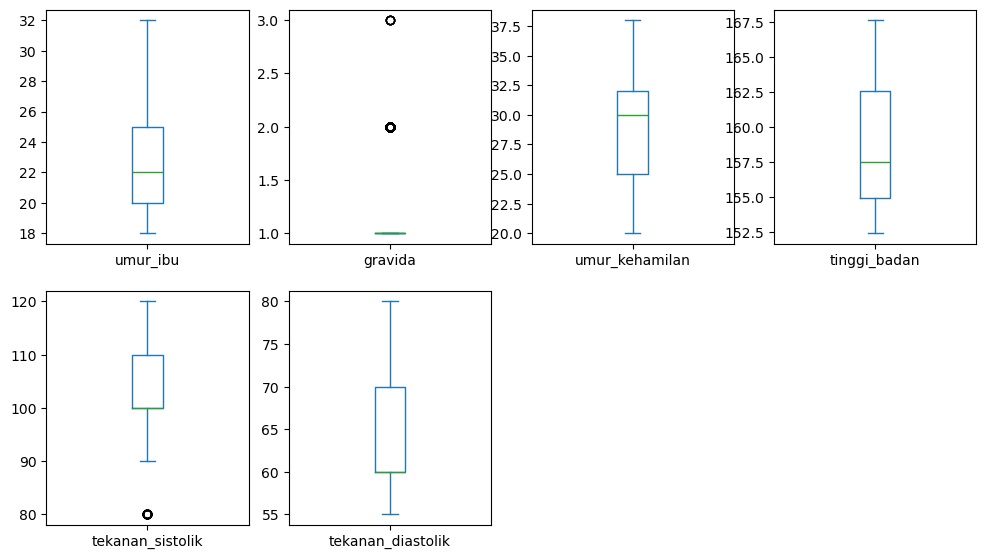

In [160]:
# Membuat plot untuk data yang outlier
df_to_plot.plot(subplots=True, layout=(4,4),kind="box", figsize=(12,14))

In [161]:
# Pilih hanya kolom numerik
numerik_cols = pregnancydf_selected.select_dtypes(include='number').columns

outlier_summary = {}

for col in numerik_cols:
    Q1 = pregnancydf_selected[col].quantile(0.25)
    Q3 = pregnancydf_selected[col].quantile(0.75)
    IQR = Q3 - Q1
    batas_bawah = Q1 - 1.5 * IQR
    batas_atas = Q3 + 1.5 * IQR

    outlier_count = ((pregnancydf_selected[col] < batas_bawah) | (pregnancydf_selected[col] > batas_atas)).sum()

    outlier_summary[col] = outlier_count

# Tampilkan jumlah outlier per kolom
print("Jumlah outlier per kolom:")
for col, count in outlier_summary.items():
    print(f"{col}: {count}")


Jumlah outlier per kolom:
umur_ibu: 0
gravida: 160
umur_kehamilan: 0
tinggi_badan: 0
tekanan_sistolik: 40
tekanan_diastolik: 0


data yang termasuk outlier masihd alam batas wajar

#### Cek value fitur kategorikal

In [162]:
pregnancydf_selected['penyakit_anemia'].unique()

array(['Negatif', 'Positif'], dtype=object)

In [163]:
pregnancydf_selected['posisi_janin'].unique()

array(['Normal', 'Abnormal'], dtype=object)

In [164]:
pregnancydf_selected['hasil_tes_VDRL'].unique()

array(['Negatif', 'Positif'], dtype=object)

In [165]:
pregnancydf_selected['hasil_tes_HbsAg'].unique()

array(['Negatif', 'Positif'], dtype=object)

In [166]:
pregnancydf_selected['kategori_tekanan_darah'].unique()

array(['Normal', 'Hipotensi', 'Prehipertensi'], dtype=object)

In [167]:
pregnancydf_selected.info()

for dtype, col in (list(zip(pregnancydf_selected.dtypes, pregnancydf_selected.columns))):
    if dtype == 'int64' or dtype == 'float64':
        print(col, dtype)
        print(pregnancydf_selected[col].min(), pregnancydf_selected[col].max())
    else:
        print(col, dtype)
        print(pregnancydf_selected[col].unique()[:3])

    print()

<class 'pandas.core.frame.DataFrame'>
Index: 955 entries, 0 to 997
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   umur_ibu                955 non-null    int64  
 1   gravida                 955 non-null    int32  
 2   umur_kehamilan          955 non-null    int32  
 3   tinggi_badan            955 non-null    float64
 4   penyakit_anemia         955 non-null    object 
 5   posisi_janin            955 non-null    object 
 6   hasil_tes_VDRL          955 non-null    object 
 7   hasil_tes_HbsAg         955 non-null    object 
 8   tekanan_sistolik        955 non-null    int32  
 9   tekanan_diastolik       955 non-null    int32  
 10  kategori_tekanan_darah  955 non-null    object 
dtypes: float64(1), int32(4), int64(1), object(5)
memory usage: 74.6+ KB
umur_ibu int64
18 32

gravida int32
[1 2 3]

umur_kehamilan int32
[38 30 35]

tinggi_badan float64
152.4 167.64

penyakit_anemia object
['

#### EDA

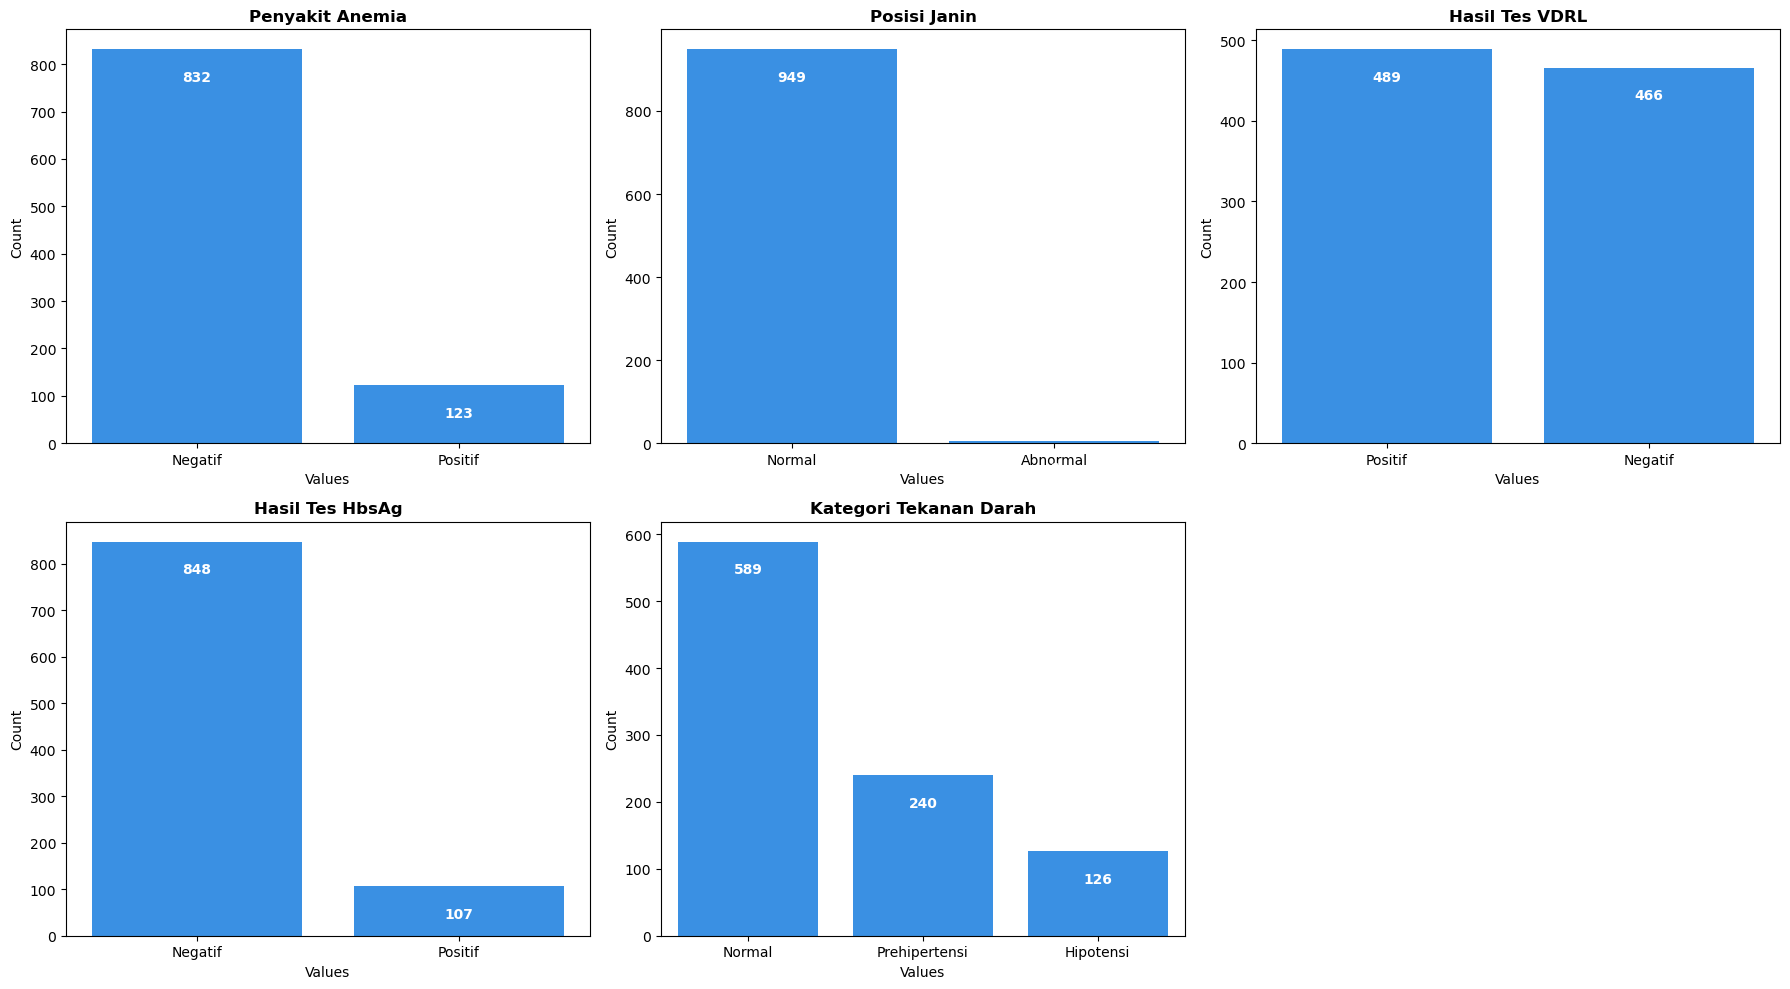

In [168]:
# Set ukuran plot dan grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()  # Ubah ke array 1D agar mudah diakses

# Daftar kolom dan judul
cols_titles = [
    ('penyakit_anemia', 'Penyakit Anemia'),
    ('posisi_janin', 'Posisi Janin'),
    ('hasil_tes_VDRL', 'Hasil Tes VDRL'),
    ('hasil_tes_HbsAg', 'Hasil Tes HbsAg'),
    ('kategori_tekanan_darah', 'Kategori Tekanan Darah')
]

# Loop untuk membuat masing-masing subplot
for i, (col, title) in enumerate(cols_titles):
    data = pregnancydf_selected[col].value_counts().reset_index()
    data.columns = ['Values', 'Count']
    ax = sns.barplot(data=data, x='Values', y='Count', color='dodgerblue', ax=axes[i])
    ax.bar_label(ax.containers[0], fmt='%i', padding=-25, color='white', fontweight='bold')
    ax.set_title(title, fontweight='bold')

# Hapus subplot kosong (jika ada)
if len(cols_titles) < len(axes):
    for j in range(len(cols_titles), len(axes)):
        fig.delaxes(axes[j])

# Atur layout rapi
plt.tight_layout()
plt.show()


In [169]:
numeric = pregnancydf_selected[['umur_ibu', 'gravida', 'umur_kehamilan',
                                'tinggi_badan', 'tekanan_sistolik', 'tekanan_diastolik']].copy()

categorical = pregnancydf_selected[['penyakit_anemia', 'posisi_janin', 'hasil_tes_VDRL',
                                    'hasil_tes_HbsAg', 'kategori_tekanan_darah']].copy()

numeric.head()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik
0,18,1,38,160.02,100,60
1,25,2,38,157.48,100,70
2,20,1,30,152.40,100,60
3,22,1,35,162.56,110,65
4,20,1,30,157.48,100,55


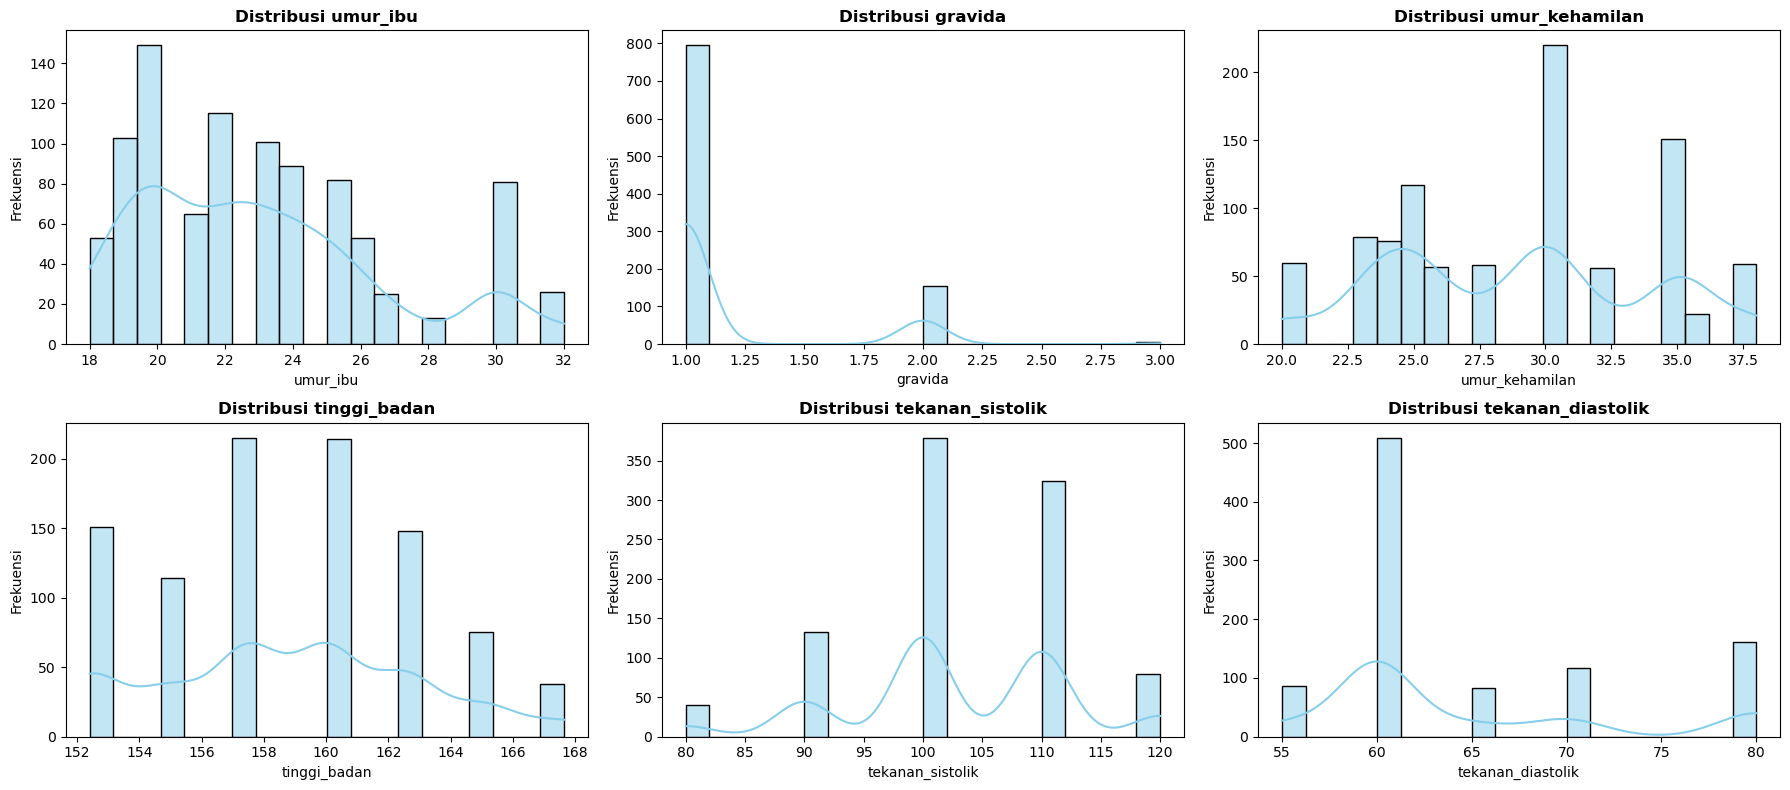

In [170]:
# Hitung jumlah kolom numerik
num_cols = numeric.columns.tolist()
n_cols = 3  # Jumlah kolom dalam grid
n_rows = math.ceil(len(num_cols) / n_cols)  # Hitung jumlah baris otomatis

# Buat subplot
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Ubah ke array 1D

# Loop untuk membuat histogram tiap kolom numerik
for i, col in enumerate(num_cols):
    sns.histplot(numeric[col], bins=20, kde=True, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Distribusi {col}', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frekuensi')
    axes[i].grid(False)

# Hapus subplot kosong
if len(num_cols) < len(axes):
    for j in range(len(num_cols), len(axes)):
        fig.delaxes(axes[j])

# Atur layout rapi
plt.tight_layout()
plt.show()


In [171]:
numeric.describe()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik
count,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000
mean,23.009424,1.172775,28.882723,158.732712,102.816754,64.575916
std,3.602776,0.391862,5.021011,4.172759,9.479258,7.950531
min,18.000000,1.000000,20.000000,152.400000,80.000000,55.000000
25%,20.000000,1.000000,25.000000,154.940000,100.000000,60.000000
50%,22.000000,1.000000,30.000000,157.480000,100.000000,60.000000
75%,25.000000,1.000000,32.000000,162.560000,110.000000,70.000000
max,32.000000,3.000000,38.000000,167.640000,120.000000,80.000000


In [172]:
pregnancydf = pd.concat([numeric, categorical], axis=1)
pregnancydf.head()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,kategori_tekanan_darah
0,18,1,38,160.02,100,60,Negatif,Normal,Negatif,Negatif,Normal
1,25,2,38,157.48,100,70,Negatif,Normal,Positif,Negatif,Normal
2,20,1,30,152.40,100,60,Negatif,Normal,Negatif,Negatif,Normal
3,22,1,35,162.56,110,65,Negatif,Normal,Positif,Negatif,Normal
4,20,1,30,157.48,100,55,Negatif,Normal,Negatif,Negatif,Hipotensi


#### Labelling

In [173]:
def realistic_labeling(pregnancydf):
    """
    Labeling yang menggabungkan dasar skor deterministik dengan 
    model ketidakpastian klinis yang bergantung pada tingkat risiko.
    """
    np.random.seed(42) # Untuk reproduktifitas
    labels = []
    scores = []
    
    for _, row in pregnancydf.iterrows():
        # --- Tahap 1: Hitung Skor Dasar Deterministik ---
        # Berdasarkan aturan maksimal yang sudah Anda tetapkan.
        score = 2
        
        # Aturan skor pasti
        if row['umur_ibu'] < 18 or row['umur_ibu'] > 35: score += 4
        if row['gravida'] >= 4: score += 4
        if row['umur_kehamilan'] > 42: score += 4
        if row['tinggi_badan'] < 145: score += 4
        if row['penyakit_anemia'] == 'Positif': score += 4
        if row['hasil_tes_VDRL'] == 'Positif': score += 4
        if row['hasil_tes_HbsAg'] == 'Positif': score += 4
        if row['kategori_tekanan_darah'] == 'Hipertensi Stage 1': score += 6
        if row['kategori_tekanan_darah'] == 'Hipertensi Stage 2': score += 8
        if row['posisi_janin'] == 'Abnormal': score += 8

        # --- Tahap 2: Tambahkan Ketidakpastian Klinis yang Realistis ---
        # Ketidakpastian lebih besar di area "abu-abu" (skor menengah)
        
        uncertainty_magnitude = np.random.choice(
            [-1, 0, 1],         # Variasi skor kecil: bisa sedikit lebih rendah, sama, atau sedikit lebih tinggi
            p=[0.15, 0.70, 0.15] # 70% kemungkinan skor tidak berubah, 15% naik/turun 1 poin
        )
            
        score += uncertainty_magnitude
        score = max(2, score) # Pastikan skor tidak di bawah minimal

        scores.append(score)
        
        # --- Tahap 3: Konversi ke Label ---
        # Threshold mungkin perlu disesuaikan berdasarkan distribusi skor baru
        if score <= 5:
            labels.append('KRR')
        elif score <= 10:
            labels.append('KRT')
        else:
            labels.append('KRST')
            
    return labels, scores

# Terapkan fungsi pelabelan
labels, scores = realistic_labeling(pregnancydf)

# Tambahkan ke dataframe
pregnancydf['skor_risiko'] = scores
pregnancydf['label_risiko'] = labels

In [174]:
# def realistic_labeling(pregnancydf):
#     """
#     Realistic labeling dengan faktor risiko yang diperbarui dan ketidakpastian klinis.
#     Faktor risiko dan skor maksimal disesuaikan berdasarkan permintaan.
#     """
#     np.random.seed(42)  # Menjamin hasil yang konsisten dan dapat direproduksi
#     labels = []
#     scores = []
    
#     for _, row in pregnancydf.iterrows():
#         # Setiap kehamilan dimulai dengan skor dasar 2
#         score = 2
        
#         # 1. Umur Ibu (maks skor 4)
#         age = row['umur_ibu']
#         if age < 18 or age > 35:
#             # Pilihan skor: [2, 3, 4] dengan probabilitas tertentu
#             score += np.random.choice([2, 3, 4], p=[0.2, 0.3, 0.5])
            
#         # 2. Gravida / Jumlah Kehamilan (maks skor 4)
#         if row['gravida'] >= 4:
#             score += np.random.choice([2, 3, 4], p=[0.2, 0.3, 0.5])
            
#         # 3. Umur Kehamilan (maks skor 4)
#         if row['umur_kehamilan'] > 42:
#             score += np.random.choice([2, 3, 4], p=[0.2, 0.3, 0.5])
            
#         # 4. Tinggi Badan (maks skor 4)
#         if row['tinggi_badan'] < 145:
#             score += np.random.choice([2, 3, 4], p=[0.2, 0.3, 0.5])

#         # 5. Tekanan Darah (maks skor 8) - Faktor Risiko Signifikan
#         if row['kategori_tekanan_darah'] in ['Hipertensi stage 1', 'Hipertensi stage 2']:
#             # Skor lebih tinggi karena risiko lebih signifikan
#             score += np.random.choice([6, 7, 8], p=[0.2, 0.3, 0.5])
            
#         # 6. Penyakit Anemia (maks skor 4)
#         if row['penyakit_anemia'] == 'Positif':
#             score += np.random.choice([2, 3, 4], p=[0.2, 0.3, 0.5])
            
#         # 7. Posisi Janin (maks skor 8) - Faktor Risiko Signifikan
#         if row['posisi_janin'] == 'Abnormal':
#             score += np.random.choice([6, 7, 8], p=[0.2, 0.3, 0.5])
            
#         # 8. Hasil Tes VDRL (maks skor 4)
#         if row['hasil_tes_VDRL'] == 'Positif':
#             score += np.random.choice([2, 3, 4], p=[0.2, 0.3, 0.5])
            
#         # 9. Hasil Tes HbsAg (maks skor 4)
#         if row['hasil_tes_HbsAg'] == 'Positif':
#             score += np.random.choice([2, 3, 4], p=[0.2, 0.3, 0.5])
        
#         # Menambahkan "Faktor X" atau ketidakpastian klinis umum
#         uncertainty = np.random.choice([-1, 0, 1], p=[0.15, 0.7, 0.15])
#         score += uncertainty
        
#         # Memastikan skor tidak pernah kurang dari skor dasar
#         score = max(2, score)
        
#         scores.append(score)
        
#         # Konversi skor numerik ke label kategori risiko
#         # Threshold ini mungkin perlu disesuaikan karena jumlah faktor risiko bertambah
#         if score <= 5:
#             labels.append('KRR') # Risiko Rendah
#         elif score <= 10:
#             labels.append('KRT') # Risiko Tinggi
#         else:
#             labels.append('KRST') # Risiko Sangat Tinggi
    
#     return labels, scores

# # Terapkan fungsi pelabelan
# labels, scores = realistic_labeling(pregnancydf)

# # Tambahkan ke dataframe
# pregnancydf['skor_risiko'] = scores
# pregnancydf['label_risiko'] = labels

In [175]:
pregnancydf.head()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,kategori_tekanan_darah,skor_risiko,label_risiko
0,18,1,38,160.02,100,60,Negatif,Normal,Negatif,Negatif,Normal,2,KRR
1,25,2,38,157.48,100,70,Negatif,Normal,Positif,Negatif,Normal,7,KRT
2,20,1,30,152.40,100,60,Negatif,Normal,Negatif,Negatif,Normal,2,KRR
3,22,1,35,162.56,110,65,Negatif,Normal,Positif,Negatif,Normal,6,KRT
4,20,1,30,157.48,100,55,Negatif,Normal,Negatif,Negatif,Hipotensi,2,KRR


In [176]:
risk_order = ['KRR', 'KRT', 'KRST']
pregnancydf['label_risiko'] = pd.Categorical(pregnancydf['label_risiko'], categories=risk_order, ordered=True)

# Menampilkan distribusi klasifikasi berbentuk persentase
print("Distribusi Persentase Label Risiko:")
print(pregnancydf['label_risiko'].value_counts(normalize=True).sort_index())

Distribusi Persentase Label Risiko:
label_risiko
KRR     0.446073
KRT     0.528796
KRST    0.025131
Name: proportion, dtype: float64


In [177]:
print(pregnancydf.iloc[2])  # Cek data di index tertentu

umur_ibu                       20
gravida                         1
umur_kehamilan                 30
tinggi_badan                152.4
tekanan_sistolik              100
tekanan_diastolik              60
penyakit_anemia           Negatif
posisi_janin               Normal
hasil_tes_VDRL            Negatif
hasil_tes_HbsAg           Negatif
kategori_tekanan_darah     Normal
skor_risiko                     2
label_risiko                  KRR
Name: 2, dtype: object


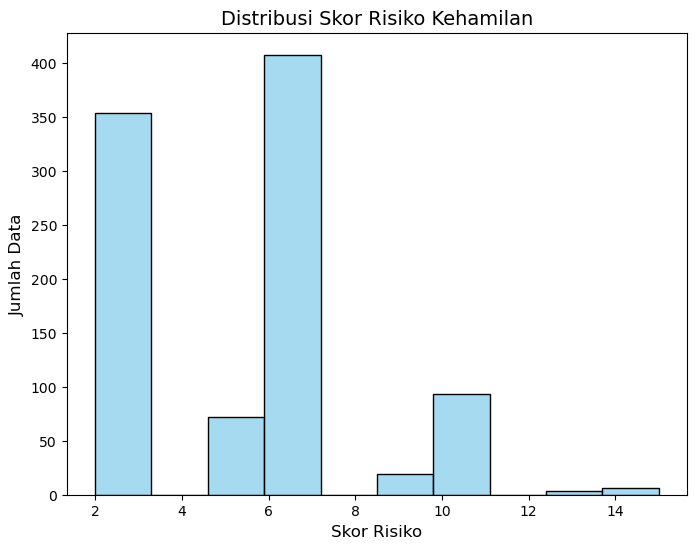

In [178]:
# Menampilkan histogram dari skor risiko
plt.figure(figsize=(8,6))  # Ukuran grafik
sns.histplot(pregnancydf['skor_risiko'], kde=False, bins=10, color='skyblue')
plt.title('Distribusi Skor Risiko Kehamilan', fontsize=14)
plt.xlabel('Skor Risiko', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.show()


Jumlah Data berdasarkan Label Risiko:
label_risiko
KRR     426
KRT     505
KRST     24
Name: count, dtype: int64


C:\Users\INFINIX\AppData\Local\Temp\ipykernel_12708\1626895838.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_risiko', data=pregnancydf, palette='Set3', order=risk_order)


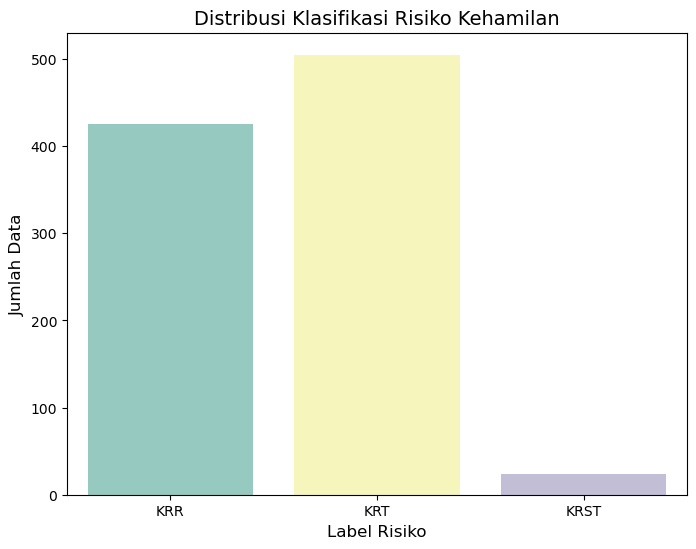

In [179]:
# Menampilkan jumlah data
print("\nJumlah Data berdasarkan Label Risiko:")
print(pregnancydf['label_risiko'].value_counts().sort_index())

# Grafik bar sesuai urutan risiko
plt.figure(figsize=(8,6))
sns.countplot(x='label_risiko', data=pregnancydf, palette='Set3', order=risk_order)
plt.title('Distribusi Klasifikasi Risiko Kehamilan', fontsize=14)
plt.xlabel('Label Risiko', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12) 
plt.show()

In [180]:
pregnancydf[pregnancydf['label_risiko'] == 'KRR']

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,kategori_tekanan_darah,skor_risiko,label_risiko
0,18,1,38,160.02,100,60,Negatif,Normal,Negatif,Negatif,Normal,2,KRR
2,20,1,30,152.40,100,60,Negatif,Normal,Negatif,Negatif,Normal,2,KRR
4,20,1,30,157.48,100,55,Negatif,Normal,Negatif,Negatif,Hipotensi,2,KRR
6,20,1,35,152.40,120,60,Negatif,Normal,Negatif,Negatif,Prehipertensi,2,KRR
8,32,3,23,160.02,90,60,Negatif,Normal,Negatif,Negatif,Normal,2,KRR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,22,1,35,167.64,110,55,Negatif,Normal,Positif,Negatif,Hipotensi,5,KRR
988,19,1,20,160.02,90,60,Negatif,Normal,Negatif,Negatif,Normal,2,KRR
990,23,1,30,154.94,100,70,Negatif,Normal,Negatif,Negatif,Normal,3,KRR
992,25,1,35,160.02,110,55,Negatif,Normal,Negatif,Negatif,Hipotensi,2,KRR


In [181]:
pregnancydf[pregnancydf['label_risiko'] == 'KRT']


,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,kategori_tekanan_darah,skor_risiko,label_risiko
1,25,2,38,157.48,100,70,Negatif,Normal,Positif,Negatif,Normal,7,KRT
3,22,1,35,162.56,110,65,Negatif,Normal,Positif,Negatif,Normal,6,KRT
5,22,1,30,154.94,100,65,Negatif,Normal,Positif,Positif,Normal,10,KRT
7,22,1,20,162.56,110,55,Negatif,Normal,Positif,Negatif,Hipotensi,7,KRT
9,21,2,28,157.48,110,80,Negatif,Normal,Positif,Negatif,Prehipertensi,6,KRT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,30,3,30,152.40,100,70,Negatif,Normal,Positif,Negatif,Normal,6,KRT
989,26,2,36,157.48,110,80,Negatif,Normal,Positif,Negatif,Prehipertensi,7,KRT
991,25,2,30,152.40,90,60,Negatif,Normal,Positif,Negatif,Normal,6,KRT
993,22,1,20,167.64,90,60,Negatif,Normal,Positif,Negatif,Normal,6,KRT


In [182]:
pregnancydf[pregnancydf['label_risiko'] == 'KRST']

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,kategori_tekanan_darah,skor_risiko,label_risiko
50,23,3,30,162.56,100,60,Positif,Normal,Negatif,Positif,Normal,11,KRST
53,20,1,30,157.48,100,65,Positif,Normal,Positif,Negatif,Normal,11,KRST
69,22,1,35,160.02,120,60,Positif,Normal,Positif,Negatif,Prehipertensi,11,KRST
113,24,1,24,157.48,90,60,Positif,Normal,Positif,Positif,Normal,14,KRST
149,25,1,38,154.94,100,65,Positif,Normal,Positif,Positif,Normal,13,KRST
243,30,1,25,157.48,110,65,Positif,Normal,Positif,Negatif,Normal,11,KRST
247,20,1,24,165.10,110,55,Positif,Normal,Positif,Negatif,Hipotensi,11,KRST
263,23,1,24,162.56,110,60,Positif,Normal,Positif,Negatif,Normal,11,KRST
275,20,2,28,152.40,90,60,Positif,Normal,Positif,Positif,Normal,15,KRST
329,27,1,25,160.02,90,60,Negatif,Normal,Positif,Positif,Normal,11,KRST


##### Interpretasi
- Setiap variabel memiliki korelasi sempurna terhadap dirinya sendiri dengan nilai 1,00, sebagaimana dapat diharapkan.

- Korelasi antara umur_ibu dan gravida sebesar 0,19 menunjukkan hubungan positif yang sangat lemah, mengindikasikan bahwa peningkatan usia ibu memiliki kecenderungan yang sangat kecil terhadap peningkatan jumlah kehamilan.

- Korelasi antara variabel tekanan_sistolik dan tekanan_diastolik sebesar 0,27 menunjukkan hubungan positif rendah. Secara klinis, hal ini dapat dimengerti karena peningkatan tekanan darah sistolik umumnya diikuti dengan peningkatan tekanan darah diastolik, meskipun dalam dataset ini hubungan tersebut tidak cukup kuat.

- Korelasi antara variabel lainnya, seperti umur_kehamilan, tinggi_badan, dan tekanan darah terhadap variabel lain, cenderung mendekati nol, menunjukkan bahwa tidak terdapat hubungan linear yang signifikan di antara fitur-fitur tersebut.

In [183]:
# Label Encoding untuk fitur biner
for col in ['penyakit_anemia', 'posisi_janin', 'hasil_tes_VDRL', 'hasil_tes_HbsAg']:
    pregnancydf[col] = LabelEncoder().fit_transform(pregnancydf[col])

# One-Hot Encoding untuk tekanan darah
pregnancydf = pd.get_dummies(pregnancydf, columns=['kategori_tekanan_darah'], drop_first=True)

In [184]:
pregnancydf.head()

,umur_ibu,gravida,umur_kehamilan,tinggi_badan,tekanan_sistolik,tekanan_diastolik,penyakit_anemia,posisi_janin,hasil_tes_VDRL,hasil_tes_HbsAg,skor_risiko,label_risiko,kategori_tekanan_darah_Normal,kategori_tekanan_darah_Prehipertensi
0,18,1,38,160.02,100,60,0,1,0,0,2,KRR,True,False
1,25,2,38,157.48,100,70,0,1,1,0,7,KRT,True,False
2,20,1,30,152.40,100,60,0,1,0,0,2,KRR,True,False
3,22,1,35,162.56,110,65,0,1,1,0,6,KRT,True,False
4,20,1,30,157.48,100,55,0,1,0,0,2,KRR,False,False


In [185]:
# pregnancydf.to_csv('preprocessed_data.csv', index=False)

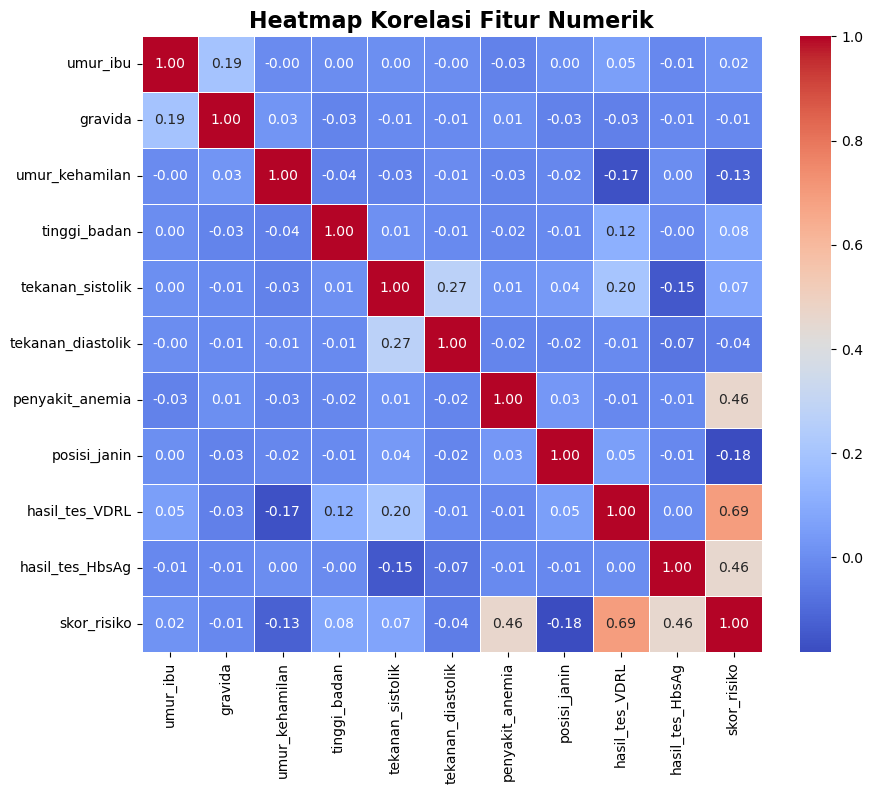

In [186]:
# Salin dataframe agar tidak mengubah aslinya
df_corr = pregnancydf.copy()

# Drop kolom kategorikal (jika ada) agar hanya kolom numerik yang dianalisis korelasinya
kolom_kategorikal = ['label_risiko']
for kolom in kolom_kategorikal:
    if kolom in df_corr.columns:
        df_corr = df_corr.drop(columns=kolom)

# Filter kolom numerik
numerik_df = df_corr.select_dtypes(include=['int', 'float'])

# Hitung korelasi
corr = numerik_df.corr()

# Tampilkan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Numerik', fontweight='bold', fontsize=16)
plt.show()


#### Data Splitting

In [187]:
# Drop fitur yang ngga dipakai
drop_columns = ['tekanan_sistolik', 'tekanan_diastolik', 'skor_risiko', 'label_risiko']
X = pregnancydf.drop(columns=drop_columns)

# Target variabel
y = pregnancydf['label_risiko']

# --- Split Data ---

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tampilkan bentuk data
print(f"Train shape:     X={X_train.shape}, y={y_train.shape}")
# print(f"Validation shape: X={X_val.shape}, y={y_val.shape}")
print(f"Test shape:      X={X_test.shape}, y={y_test.shape}")

Train shape:     X=(764, 10), y=(764,)
Test shape:      X=(191, 10), y=(191,)


In [188]:
print(X_train.columns.tolist())

['umur_ibu', 'gravida', 'umur_kehamilan', 'tinggi_badan', 'penyakit_anemia', 'posisi_janin', 'hasil_tes_VDRL', 'hasil_tes_HbsAg', 'kategori_tekanan_darah_Normal', 'kategori_tekanan_darah_Prehipertensi']



Memulai proses GridSearchCV dengan Pipeline...
Fitting 10 folds for each of 24 candidates, totalling 240 fits
GridSearchCV selesai.

Parameter terbaik yang ditemukan: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_split': 30}
Skor F1-Macro CV terbaik (metode pipeline): 0.6766

Melakukan prediksi pada data uji...

--- Laporan Klasifikasi pada Data Uji ---
              precision    recall  f1-score   support

         KRR       0.95      0.87      0.91        85
        KRST       0.07      0.20      0.10         5
         KRT       0.86      0.83      0.84       101

    accuracy                           0.83       191
   macro avg       0.62      0.63      0.62       191
weighted avg       0.88      0.83      0.85       191


--- Confusion Matrix ---


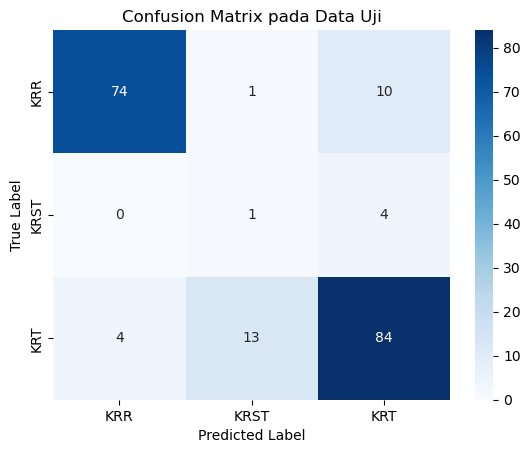

In [189]:
from imblearn.pipeline import Pipeline # <--- IMPORT INI

# --- 3. PEMBUATAN PIPELINE DAN SETUP HYPERPARAMETER TUNING ---

# 1. Buat sebuah Pipeline.
# Ini adalah daftar langkah-langkah yang akan dieksekusi secara berurutan.
# Nama langkah ('smote', 'classifier') adalah bebas, tetapi akan digunakan di param_grid.
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# 2. Definisikan skema cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 3. Definisikan grid parameter.
# PENTING: Nama setiap parameter harus diawali dengan nama langkah di pipeline,
# diikuti oleh dua garis bawah (double underscore).
# Contoh: 'classifier__max_depth' bukan hanya 'max_depth'.
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [10, 20, 30],
    'classifier__criterion': ['gini', 'entropy']
}


# --- 4. EKSEKUSI PROSES TUNING DENGAN PIPELINE ---

# 4. Inisialisasi GridSearchCV.
# Estimatornya sekarang adalah 'pipeline' yang sudah kita buat.
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=skf,                 # Skema validasi silang
    scoring='f1_macro',     # Metrik evaluasi yang tepat
    n_jobs=-1,              # Menggunakan semua core CPU
    verbose=1               # Menampilkan progress
)

# 5. Latih GridSearchCV pada data training ASLI (TIDAK di-resample).
# Pipeline akan secara otomatis menangani penerapan SMOTE di setiap fold CV.
print("\nMemulai proses GridSearchCV dengan Pipeline...")
grid_search.fit(X_train, y_train)
print("GridSearchCV selesai.")


# --- 5. ANALISIS HASIL DAN EVALUASI AKHIR ---

# 6. Tampilkan hasil dari proses tuning.
# Skor CV ini adalah estimasi yang paling jujur dan tidak bias.
print(f"\nParameter terbaik yang ditemukan: {grid_search.best_params_}")
print(f"Skor F1-Macro CV terbaik (metode pipeline): {grid_search.best_score_:.4f}")

# 7. Ambil model/pipeline terbaik yang sudah dilatih secara otomatis.
best_pipeline = grid_search.best_estimator_

# 8. Lakukan prediksi pada data UJI (X_test).
print("\nMelakukan prediksi pada data uji...")
y_pred = best_pipeline.predict(X_test)

# 9. Tampilkan laporan evaluasi lengkap pada data uji.
print("\n--- Laporan Klasifikasi pada Data Uji ---")
print(classification_report(y_test, y_pred))

# 10. Tampilkan Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
# Untuk label, kita bisa ambil dari pipeline yang sudah dilatih
class_names = best_pipeline.named_steps['classifier'].classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix pada Data Uji')
plt.show()

#### Resampling Data for Imbalance Dataset

In [190]:
# # Tampilkan distribusi SEBELUM SMOTE (praktik baik)
# print("Distribusi Label Sebelum SMOTE:")
# print(y_train.value_counts(), '\n')

# # Inisialisasi SMOTE dengan strategi yang lebih umum
# # Gunakan nilai k_neighbors yang aman, misal 5 atau minimal 3
# smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5) 

# # Lakukan fit_resample pada data training
# # INI ADALAH DATA YANG AKAN DIGUNAKAN UNTUK MELATIH MODEL
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Tampilkan distribusi SETELAH SMOTE
# print("Distribusi Label Setelah SMOTE:")
# print(pd.Series(y_train_resampled).value_counts(), '\n')

#### Model Deployment

In [191]:
# # --- TAHAP 1: SETUP KOMPONEN ---

# # Inisialisasi model dasar TANPA class_weight
# dt_base = DecisionTreeClassifier(random_state=42)

# #  Inisialisasi skema cross-validation
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Definisikan grid parameter
# param_grid = {
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [10, 20, 30],
#     'criterion': ['gini', 'entropy']
# }

# # --- TAHAP 2: PROSES TUNING ---

# # Inisialisasi GridSearchCV
# grid_search = GridSearchCV(
#     estimator=dt_base, 
#     param_grid=param_grid, 
#     cv=skf,
#     scoring='f1_macro',
#     n_jobs=-1,
#     verbose=1
# )

# grid_search.fit(X_train_resampled, y_train_resampled) # <--- PERUBAHAN PALING PENTING

# # --- TAHAP 3: ANALISIS HASIL ---

# # Tampilkan hasil tuning
# print(f"\nParameter terbaik: {grid_search.best_params_}")
# print(f"Skor F1-Macro CV terbaik: {grid_search.best_score_:.4f}")

# # Ambil model terbaik
# best_model = grid_search.best_estimator_

# # --- TAHAP 4: UJIAN AKHIR PADA DATA TEST (ASLI) ---

# # Lakukan prediksi pada data test yang ASLI (tidak di-SMOTE)
# print("\nMelakukan prediksi pada data test...")
# y_pred = best_model.predict(X_test)


Test Accuracy: 0.8324607329842932

Classification Report:
               precision    recall  f1-score   support

         KRR       0.95      0.87      0.91        85
        KRST       0.07      0.20      0.10         5
         KRT       0.86      0.83      0.84       101

    accuracy                           0.83       191
   macro avg       0.62      0.63      0.62       191
weighted avg       0.88      0.83      0.85       191



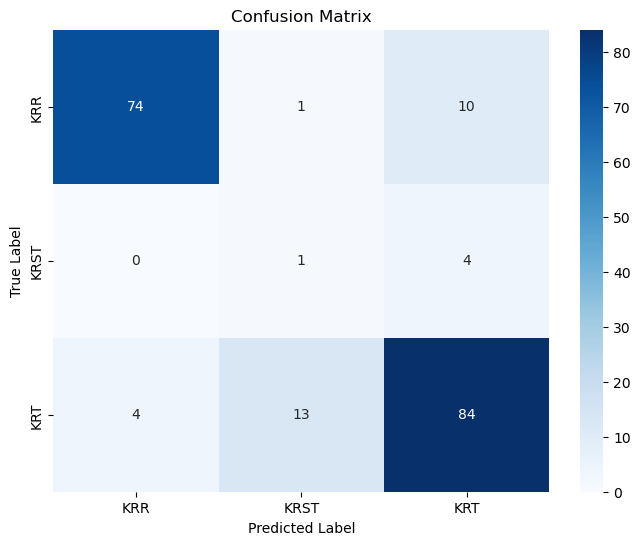

In [192]:
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show() 


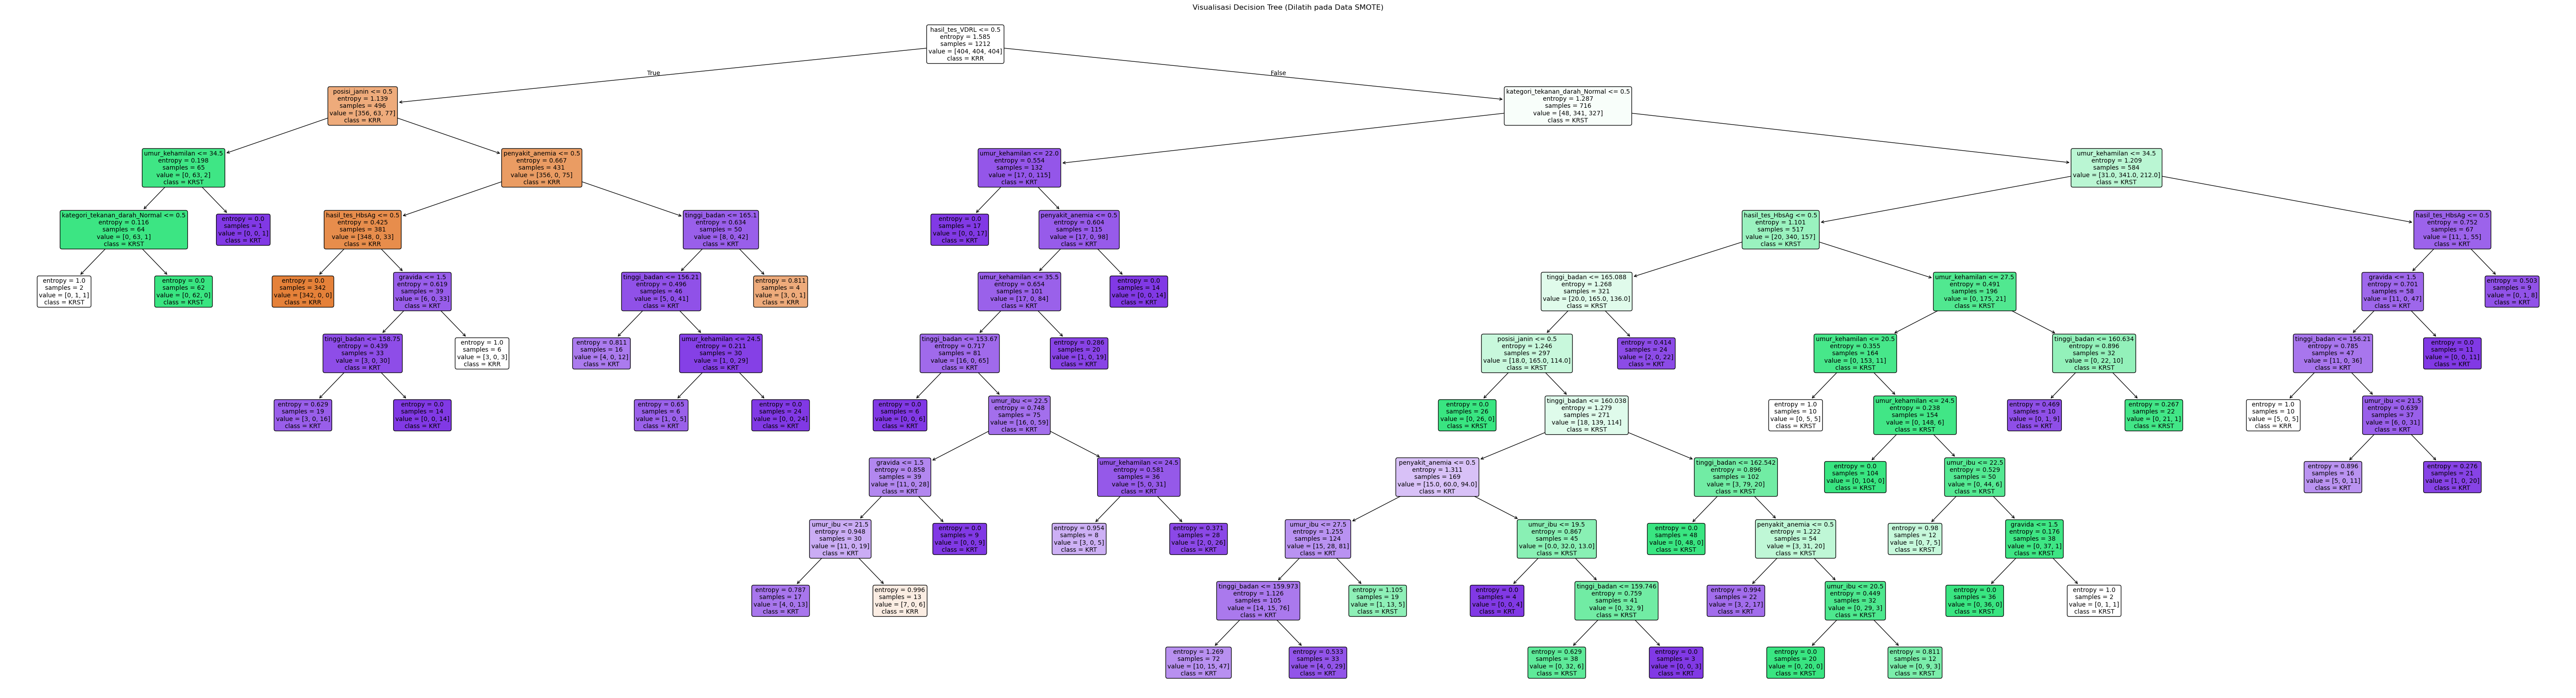

In [193]:
# Visualisasi Decision Tree

plt.figure(figsize=(75, 20))
plot_tree(
    best_model,
    feature_names=X.columns,
    class_names=sorted(y.unique()), # Cara aman untuk mendapatkan urutan yang benar
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Visualisasi Decision Tree (Dilatih pada Data SMOTE)")
plt.show()

In [194]:
# # Path untuk menyimpan model
# model_path = "decision_tree_model.pkl"

# # Menyimpan model menggunakan pickle
# with open(model_path, "wb") as file:
#     pickle.dump(model, file)

# print(f"Model berhasil disimpan di: {model_path}")
